In [6]:
import os
import shutil
import datetime
import numpy as np 
import pandas as pd 

In [7]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [8]:
logs_dir = './logs/'
if os.path.exists(logs_dir):
    shutil.rmtree(logs_dir)

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = 'C:/Users/Anjil/Documents/ProductClassification/data_4_classes/train'
test_dir = 'C:/Users/Anjil/Documents/ProductClassification/data_4_classes/test'
train_csv = 'C:/Users/Anjil/Documents/ProductClassification/data_4_classes/Training_set.csv'
test_csv = 'C:/Users/Anjil/Documents/ProductClassification/data_4_classes/Testing_set.csv'

train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=4,
    #width_shift_range=0.1,
    #height_shift_range=0.1,
    #shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,                                         # changed from 32
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col='filename',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,                                          # changed from 32
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_dir,
    x_col='filename',
    y_col=None,
    target_size=(224, 224),
    batch_size=32,                                           # changed from 32
    class_mode=None,
    shuffle=False
)

Found 613 validated image filenames belonging to 5 classes.
Found 153 validated image filenames belonging to 5 classes.
Found 50 validated image filenames.


In [10]:
class_labels = list(train_generator.class_indices.keys())
print('class_labels:',class_labels)

class_labels: ['MBE', 'MDR-GR', 'MLN-YL', 'MTR', 'person']


In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, regularizers
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) 
x = Dense(256, activation='relu',kernel_regularizer=regularizers.l2(0.001))(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001)
history = model.fit( 
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback, reduce_lr],
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/10
19/19 [==============================] - 24s 1s/step - loss: 1.8735 - accuracy: 0.4647 - val_loss: 0.9662 - val_accuracy: 0.8828 - lr: 1.0000e-04
Epoch 2/10
19/19 [==============================] - 19s 982ms/step - loss: 0.9189 - accuracy: 0.8864 - val_loss: 0.5503 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 3/10
19/19 [==============================] - 20s 1s/step - loss: 0.6061 - accuracy: 0.9880 - val_loss: 0.4744 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 4/10
19/19 [==============================] - 19s 987ms/step - loss: 0.5334 - accuracy: 0.9983 - val_loss: 0.4521 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 5/10
19/19 [==============================] - 19s 1s/step - loss: 0.4821 - accuracy: 1.0000 - val_loss: 0.4398 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 6/10
19/19 [==============================] - 19s 1s/step - loss: 0.4698 - accuracy: 0.9983 - val_loss: 0.4307 - val_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 7/10
19/19 [==============================] - 

In [5]:
# val_loss, val_accuracy = model.evaluate(validation_generator)
# print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

In [15]:
for layer in base_model.layers[-60:]:
    layer.trainable = True

from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=20,
    validation_data=validation_generator,
    callbacks=[tensorboard_callback],
    validation_steps=validation_generator.n // validation_generator.batch_size
)

Epoch 1/20
19/19 [==============================] - 22s 1s/step - loss: 0.6100 - accuracy: 0.9742 - val_loss: 0.4170 - val_accuracy: 1.0000
Epoch 2/20
19/19 [==============================] - 19s 1s/step - loss: 0.4998 - accuracy: 0.9966 - val_loss: 0.4163 - val_accuracy: 1.0000
Epoch 3/20
19/19 [==============================] - 19s 996ms/step - loss: 0.4679 - accuracy: 0.9983 - val_loss: 0.4160 - val_accuracy: 1.0000
Epoch 4/20
19/19 [==============================] - 19s 991ms/step - loss: 0.4558 - accuracy: 1.0000 - val_loss: 0.4153 - val_accuracy: 1.0000
Epoch 5/20
19/19 [==============================] - 19s 994ms/step - loss: 0.4542 - accuracy: 1.0000 - val_loss: 0.4149 - val_accuracy: 1.0000
Epoch 6/20
19/19 [==============================] - 19s 982ms/step - loss: 0.4450 - accuracy: 1.0000 - val_loss: 0.4146 - val_accuracy: 1.0000
Epoch 7/20
19/19 [==============================] - 19s 994ms/step - loss: 0.4390 - accuracy: 1.0000 - val_loss: 0.4143 - val_accuracy: 1.0000
Epoch

In [ ]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 20316), started 5 days, 18:08:42 ago. (Use '!kill 20316' to kill it.)

In [16]:
model.save('IMGneT_100_7_29.h5')

In [17]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation accuracy: {val_accuracy * 100:.2f}%')

5/5 [==============================] - 4s 629ms/step - loss: 0.4102 - accuracy: 1.0000
Validation accuracy: 100.00%


class_labels: ['MBE', 'MDR-GR', 'MLN-YL', 'MTR', 'person']
1/1 [==============================] - 0s 377ms/step
predictions: [[0.03796291 0.20075527 0.01429859 0.74698323]]


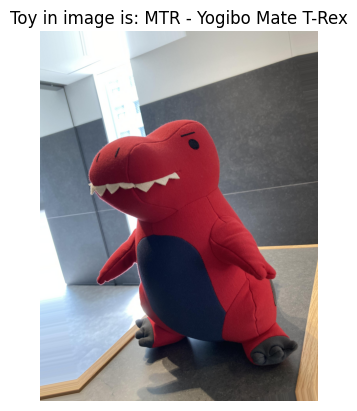

Toy in image is: MTR - Yogibo Mate T-Rex


In [19]:
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

csv_file = 'C:/Users/Anjil/Documents/ProductClassification/yogibo_product.csv'
product_df = pd.read_csv(csv_file, on_bad_lines='skip')

relevant_classes = ['MBE', 'MDR-GR','MTR','MLN-YL']  
filtered_df = product_df[product_df['pdt_pro_cd'].isin(relevant_classes)]

class_to_product = dict(zip(filtered_df['pdt_pro_cd'], filtered_df['pdt_nm_us']))

model = load_model('IMGneT_103_7_23.h5')


img = 'C:/Users/Anjil/Documents/ProductClassification/data_4_classes/test/MTR123aug_0_2722.jpg'
frame = cv2.imread(img)
frame_resized = cv2.resize(frame, (224, 224))
frame_resized = img_to_array(frame_resized) / 255.0
frame_resized = np.expand_dims(frame_resized, axis=0)

class_labels = list(train_generator.class_indices.keys())
print('class_labels:',class_labels)

predictions = model.predict(frame_resized)
print('predictions:',predictions)
predicted_class_idx = np.argmax(predictions)
predicted_class = class_labels[predicted_class_idx]
product_name = class_to_product.get(predicted_class, "Unknown Product")

plt.imshow(frame[..., ::-1])  # Convert BGR to RGB
plt.axis('off')
plt.title(f'Toy in image is: {predicted_class} - {product_name}')
plt.show()

print(f'Toy in image is: {predicted_class} - {product_name}')